# G27
Dave Brunner

### Download Data

The data is taken from http://archive.ics.uci.edu/ml/machine-learning-databases/00240/, but you can have it in the form of the UCI-HAR-Dataset.zip.

Extract it to the folder of your notebook with the solution (or suitably adjust the paths to training and test data specified below (TRAIN, TEST).  

Spcifically, the split into training and testing data is already done. The dataset contains 7352 training and 2947 test samples.  

Each sample consists of nine timeseries of float values, each of length 128.

The nine timeseries are collected by an accelerometer and a gyroscope that contain information about the motion and the orientation, respectively.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import ReLU, Sequential, Conv1d, BatchNorm1d, MaxPool1d, Dropout, Linear, Flatten

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Device is set to: {device}")

Device is set to: mps


### Load Data

In [3]:
# Useful Constants
TRAIN = "UCI_HAR_Dataset/train/"
TEST = "UCI_HAR_Dataset/test/"

# x-values, 'signals'
# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]
X_train_signals_paths = [TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES]
X_test_signals_paths = [TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES]

# y-values, 'labels'
#Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]
N_CLASSES = len(LABELS)
y_train_path = TRAIN + "y_train.txt"
y_test_path = TEST + "y_test.txt"

In [4]:
# Load "X" (the neural network's training and testing inputs)
def load_X(X_signals_paths):
    X_signals = []
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    return np.transpose(np.array(X_signals), (1, 2, 0))


X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
n_input_signals = X_train.shape[2]
signal_sequence_length = X_train.shape[1]
print(f'X_train shape: {X_train.shape}\n'
      f'X_test shape: {X_test.shape}\n'
      f'Number of input signals: {n_input_signals}\n'
      f'Signal sequence length: {signal_sequence_length}')

X_train shape: (7352, 128, 9)
X_test shape: (2947, 128, 9)
Number of input signals: 9
Signal sequence length: 128


In [5]:
# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1


def one_hot(y, n_classes):
    y = y.reshape(len(y))
    return np.eye(n_classes)[np.array(y, dtype=np.int32)]


def label_from_onehot(vectors):
    indices = []
    for vector in vectors:
        indices.append(np.argmax(vector))
    return np.array(indices)


Y_train = load_y(y_train_path)
Y_test = load_y(y_test_path)
print(Y_train.shape, Y_test.shape)

(7352, 1) (2947, 1)


In [6]:
# One-hot encoding
Y_train = one_hot(Y_train, N_CLASSES)
Y_test = one_hot(Y_test, N_CLASSES)
print(f'Y_train shape: {Y_train.shape}\n'
      f'Y_test shape: {Y_test.shape}')

Y_train shape: (7352, 6)
Y_test shape: (2947, 6)


#### Plot some samples

In [7]:
X_train_per_class = {}
for c in range(N_CLASSES):
    mask = ...  # select sample of given class c
    X_train_per_class[c] = X_train[mask]

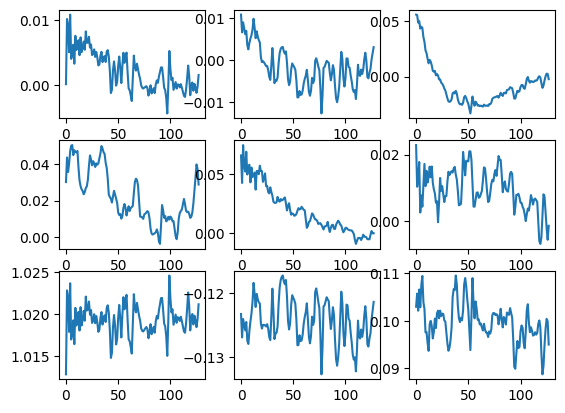

In [8]:
def plot_lines(X, nsamples):
    t = range(128)
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        for j in range(np.minimum(X.shape[0], nsamples)):
            plt.plot(t, X[j, :, i])
    plt.show()


plot_lines(X_train_per_class[1], 1)

In [9]:
# Input Data
training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
means = np.mean(X_train, axis=(0, 1))
stdevs = np.std(X_train, axis=(0, 1))

print("X shape, Y_shape:")
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print()
print("Mean / Stdev for each feature:")
for i in range(9):
    print("%7.4f | %7.4f" % (means[i], stdevs[i]))

X shape, Y_shape:
(7352, 128, 9) (7352, 6)
(2947, 128, 9) (2947, 6)

Mean / Stdev for each feature:
-0.0006 |  0.1948
-0.0003 |  0.1224
-0.0003 |  0.1069
 0.0005 |  0.4068
-0.0008 |  0.3819
 0.0001 |  0.2557
 0.8047 |  0.4141
 0.0288 |  0.3910
 0.0865 |  0.3578


### Dataset

If suitable specify Dataset (e.g. in PyTorch).

In [10]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32).to(device)

In [11]:
print(f'Y_train_tensor shape: {Y_train_tensor.shape}\n'
      f'Y_test_tensor shape: {Y_test_tensor.shape}')

Y_train_tensor shape: torch.Size([7352, 6])
Y_test_tensor shape: torch.Size([2947, 6])


### Normalization



In [12]:
mean = torch.mean(X_train_tensor)
std = torch.std(X_train_tensor)

X_train_tensor_norm = (X_train_tensor - mean) / std
X_test_tensor_norm = (X_test_tensor - mean) / std

In [13]:
print(f'Std of X_train_tensor_norm: {torch.std(X_train_tensor_norm):.4f}\n'
      f'Std of X_train_tensor     : {torch.std(X_test_tensor):.4f}\n'
      '----------------------------------\n'
      f'Std of X_test_tensor_norm: {torch.std(X_test_tensor_norm):.4f}\n'
      f'Std of X_test_tensor     : {torch.std(X_test_tensor):.4f}')

Std of X_train_tensor_norm: 1.0000
Std of X_train_tensor     : 0.3957
----------------------------------
Std of X_test_tensor_norm: 0.9839
Std of X_test_tensor     : 0.3957


In [14]:
training_data = torch.utils.data.TensorDataset(X_train_tensor_norm, Y_train_tensor)
test_data = torch.utils.data.TensorDataset(X_test_tensor_norm, Y_test_tensor)

assert len(training_data) == len(X_train)
assert len(test_data) == len(Y_test)

del X_train
del Y_train
del X_test
del Y_test

## Specify and Train Models

Try different architectures to solve the activity recognition problem.

At minimum implement
* Model with a single layer of SimpleRNN
* Model with a single layer of LSTM
* Model with several layers of LSTMs
* Model with several CNN layers
* MLP

Try with different number of units. Add regularisation if needed (e.g. when working with MLPs).

Report about your findings.

### Single Layer SimpleRNN

In [15]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, num_classes):
        super().__init__()

        # Defining the number of h layers and the nodes in each layer
        self.layer_size = layer_size
        self.hidden_size = hidden_size

        # RNN layers
        self.rnn = nn.RNN(input_size, hidden_size, layer_size, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.rnn(x)
        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1]
        # Convert the final state to our desired output shape (batch_size, output_size)
        out = self.fc(out)

        return out

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, num_classes):
        super().__init__()

        # Defining the number of h layers and the nodes in each layer
        self.layer_size = layer_size
        self.hidden_size = hidden_size

        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, layer_size, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.lstm(x)
        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1]
        # Convert the final state to our desired output shape (batch_size, output_size)
        out = self.fc(out)

        return out

In [17]:
class PrintForward(nn.Module):
    @staticmethod
    def forward(x):
        print(x.shape)
        return x

class CNN_1D(nn.Module):
    def __init__(self, input_size, num_classes, activation_function=ReLU(), dropout_rate=0):
        super(CNN_1D, self).__init__()
        self.model = Sequential(
            Conv1d(input_size, 32, 1),  # 32 * 128
            BatchNorm1d(32),
            activation_function,
            

            Conv1d(32, 64, 3, 1),  # 64 * 126
            BatchNorm1d(64),
            activation_function,

            MaxPool1d(2),  # 64 * 63

            Conv1d(64, 128, 3, 1),  # 128 * 61
            BatchNorm1d(128),
            activation_function,

            Dropout(dropout_rate),
            Flatten(),
            Linear(128, 128),
            BatchNorm1d(128),
            activation_function,

            Linear(128, num_classes),
        )

    def forward(self, x):
        return self.model(x)

In [18]:
def train_model(model, n_epochs, batch_size, optimizer, criterion, gradient_clipping=True):
    accuracy_hist_train = []
    accuracy_hist_test = []
    loss_hist_train = []
    loss_hist_test = []

    train_loader = torch.utils.data.DataLoader(dataset=training_data, batch_size=batch_size, shuffle=True)
    train_loader_eval = torch.utils.data.DataLoader(dataset=training_data, batch_size=len(training_data), shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=len(test_data), shuffle=False)

    print('Training model...')
    for epoch in range(n_epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            # Pass data through the network
            output = model(data)
            # Calculate loss
            loss = criterion(output, target)
            # Backpropagate. Updates the gradients buffer on each parameter
            loss.backward()
            # Clip gradients to prevent exploding gradients
            if gradient_clipping:
                nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            # Update weights
            optimizer.step()

        # test 
        with torch.no_grad():
            # train set ----------------
            correct = 0
            total = 0
            loss = 0
            for data, target in train_loader_eval:
                pred = model(data)
                loss += criterion(pred, target).item()
                _, predicted = torch.max(pred.data, 1)
                target = torch.max(target, 1)[1]
                total += target.size(0)
                correct += (predicted == target).sum().item()
            accuracy = correct / total
            accuracy_hist_train.append(accuracy)
            loss_hist_train.append(loss)

            # test set ----------------
            correct = 0
            total = 0
            loss = 0
            for data, target in test_loader:
                pred = model(data)
                loss += criterion(pred, target).item()
                _, predicted = torch.max(pred.data, 1)
                target = torch.max(target, 1)[1]
                total += target.size(0)
                correct += (predicted == target).sum().item()
            accuracy = correct / total
            accuracy_hist_test.append(accuracy)
            loss_hist_test.append(loss)

        print(
            f'Epoch {epoch + 1}, Loss: train={loss_hist_train[-1]:.4f}, test={loss_hist_test[-1]:.4f} | Accuracy: train={accuracy_hist_train[-1]:.4f}, test={accuracy_hist_test[-1]:.4f}')
    return {'train': [accuracy_hist_train, loss_hist_train], 'test': [accuracy_hist_test, loss_hist_test]}


def print_hist(history, title):
    plt.figure(1, figsize=(15, 5))
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    plt.plot(history['train'][1], label='Train Loss')
    plt.plot(history['test'][1], label='Test Loss')
    plt.xlabel('Epoch')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.ylim(0, 1)
    plt.plot(history['train'][0], label='Train accuracy')
    plt.plot(history['test'][0], label='Test accuracy')
    plt.xlabel('Epoch')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

Training model...
Epoch 1, Loss: train=1.1215, test=1.2168 | Accuracy: train=0.5109, test=0.4608
Epoch 2, Loss: train=0.9989, test=1.1191 | Accuracy: train=0.5811, test=0.5226
Epoch 3, Loss: train=0.9809, test=1.1447 | Accuracy: train=0.5646, test=0.5154
Epoch 4, Loss: train=0.7782, test=1.0214 | Accuracy: train=0.6351, test=0.5579
Epoch 5, Loss: train=1.3664, test=1.4538 | Accuracy: train=0.4812, test=0.4523
Epoch 6, Loss: train=1.0055, test=1.1157 | Accuracy: train=0.6098, test=0.5548
Epoch 7, Loss: train=0.8445, test=0.9762 | Accuracy: train=0.6876, test=0.6047
Epoch 8, Loss: train=0.7102, test=0.8486 | Accuracy: train=0.7246, test=0.6471
Epoch 9, Loss: train=0.8091, test=1.0135 | Accuracy: train=0.6817, test=0.6125
Epoch 10, Loss: train=0.8580, test=0.9225 | Accuracy: train=0.6413, test=0.6101
Epoch 11, Loss: train=0.6999, test=0.8886 | Accuracy: train=0.6823, test=0.6298
Epoch 12, Loss: train=0.9395, test=1.1384 | Accuracy: train=0.5642, test=0.5165
Epoch 13, Loss: train=0.6653, t

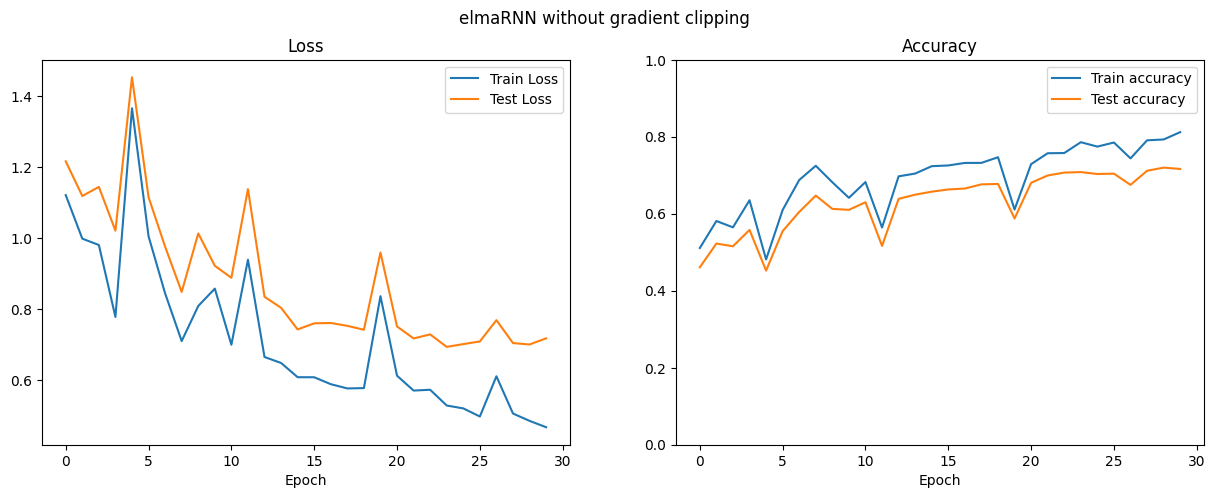

In [19]:
elmaRNN = RNNModel(input_size=n_input_signals, hidden_size=64, layer_size=1, num_classes=N_CLASSES).to(device)

adam = torch.optim.Adam(elmaRNN.parameters(), lr=0.001)
cross_entropy = nn.CrossEntropyLoss()

history = train_model(model=elmaRNN, n_epochs=30, batch_size=128, optimizer=adam, criterion=cross_entropy, gradient_clipping=False)

print_hist(history, 'elmaRNN without gradient clipping')
del elmaRNN

Training model...
Epoch 1, Loss: train=1.1564, test=1.2736 | Accuracy: train=0.4630, test=0.4299
Epoch 2, Loss: train=1.0276, test=1.1373 | Accuracy: train=0.5673, test=0.5182
Epoch 3, Loss: train=0.8649, test=1.0625 | Accuracy: train=0.6349, test=0.5585
Epoch 4, Loss: train=0.8219, test=0.9784 | Accuracy: train=0.6230, test=0.5653
Epoch 5, Loss: train=0.7783, test=0.8678 | Accuracy: train=0.6697, test=0.6291
Epoch 6, Loss: train=1.0670, test=1.1703 | Accuracy: train=0.5067, test=0.4537
Epoch 7, Loss: train=0.8623, test=0.9860 | Accuracy: train=0.6511, test=0.5996
Epoch 8, Loss: train=0.6852, test=0.7895 | Accuracy: train=0.6895, test=0.6491
Epoch 9, Loss: train=0.7768, test=0.8810 | Accuracy: train=0.6504, test=0.6179
Epoch 10, Loss: train=0.8428, test=0.9535 | Accuracy: train=0.6198, test=0.5792
Epoch 11, Loss: train=0.6605, test=0.7950 | Accuracy: train=0.6908, test=0.6552
Epoch 12, Loss: train=0.6316, test=0.7570 | Accuracy: train=0.7276, test=0.6729
Epoch 13, Loss: train=0.8776, t

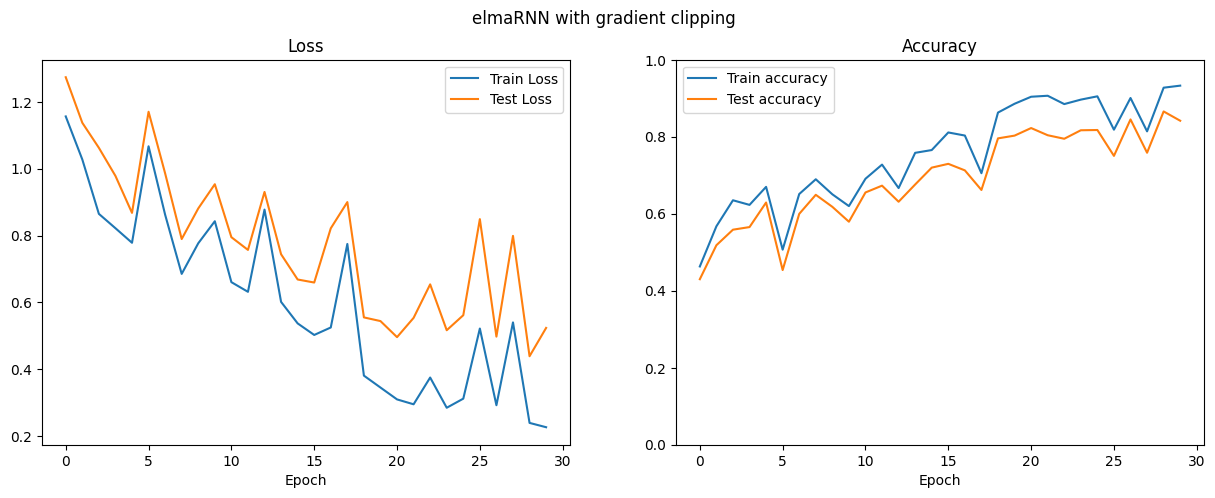

In [20]:
elmaRNN = RNNModel(input_size=n_input_signals, hidden_size=64, layer_size=1, num_classes=N_CLASSES).to(device)

adam = torch.optim.Adam(elmaRNN.parameters(), lr=0.001)
cross_entropy = nn.CrossEntropyLoss()

history = train_model(model=elmaRNN, n_epochs=30, batch_size=128, optimizer=adam, criterion=cross_entropy, gradient_clipping=True)

print_hist(history, 'elmaRNN with gradient clipping')
del elmaRNN

Training model...
Epoch 1, Loss: train=1.0953, test=1.1742 | Accuracy: train=0.5090, test=0.4645
Epoch 2, Loss: train=1.0960, test=1.1945 | Accuracy: train=0.5535, test=0.5008
Epoch 3, Loss: train=0.8525, test=1.0900 | Accuracy: train=0.6553, test=0.5636
Epoch 4, Loss: train=0.8141, test=0.9579 | Accuracy: train=0.6344, test=0.5898
Epoch 5, Loss: train=0.7304, test=0.8879 | Accuracy: train=0.6915, test=0.6379
Epoch 6, Loss: train=0.9944, test=1.1512 | Accuracy: train=0.5571, test=0.4975
Epoch 7, Loss: train=1.0347, test=1.1212 | Accuracy: train=0.5668, test=0.5246
Epoch 8, Loss: train=0.6271, test=0.7384 | Accuracy: train=0.7100, test=0.6569
Epoch 9, Loss: train=0.5279, test=0.6860 | Accuracy: train=0.7799, test=0.7197
Epoch 10, Loss: train=0.4588, test=0.7182 | Accuracy: train=0.8123, test=0.7316
Epoch 11, Loss: train=0.4277, test=0.6070 | Accuracy: train=0.8555, test=0.7879
Epoch 12, Loss: train=0.3662, test=0.6934 | Accuracy: train=0.8685, test=0.7808
Epoch 13, Loss: train=0.2887, t

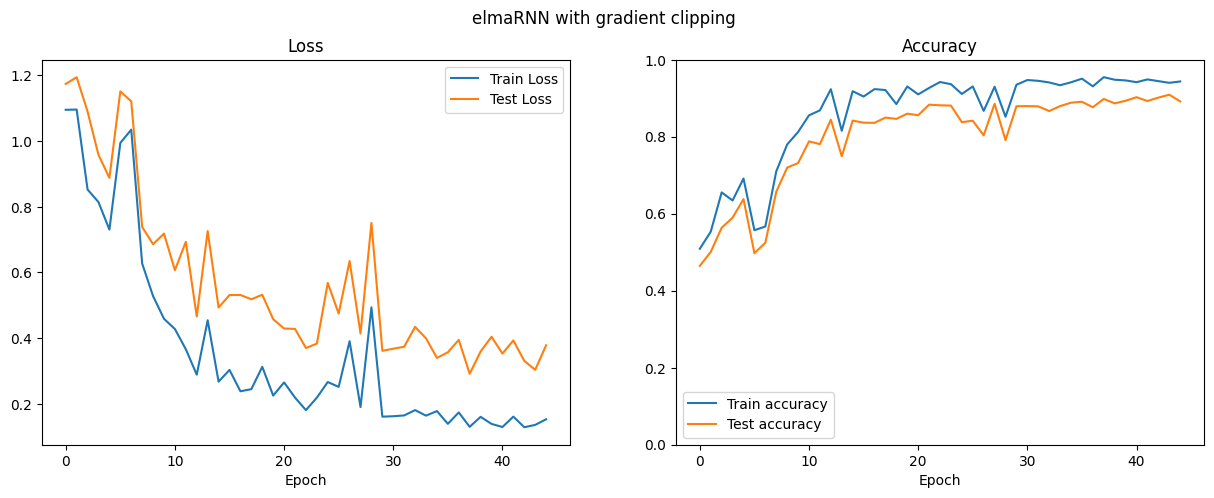

In [21]:
elmaRNN = RNNModel(input_size=n_input_signals, hidden_size=128, layer_size=1, num_classes=N_CLASSES).to(device)

adam = torch.optim.Adam(elmaRNN.parameters(), lr=0.001)
cross_entropy = nn.CrossEntropyLoss()

history = train_model(model=elmaRNN, n_epochs=45, batch_size=128, optimizer=adam, criterion=cross_entropy, gradient_clipping=True)

print_hist(history, 'elmaRNN with gradient clipping')
del elmaRNN

Training model...
Epoch 1, Loss: train=1.3258, test=1.4432 | Accuracy: train=0.4954, test=0.4472
Epoch 2, Loss: train=0.8744, test=1.0278 | Accuracy: train=0.6417, test=0.5881
Epoch 3, Loss: train=0.7984, test=0.8769 | Accuracy: train=0.6487, test=0.6074
Epoch 4, Loss: train=0.6496, test=0.7457 | Accuracy: train=0.7208, test=0.6722
Epoch 5, Loss: train=0.5812, test=0.7041 | Accuracy: train=0.7557, test=0.7048
Epoch 6, Loss: train=0.4773, test=0.7753 | Accuracy: train=0.8315, test=0.7445
Epoch 7, Loss: train=0.3228, test=0.5493 | Accuracy: train=0.8900, test=0.8222
Epoch 8, Loss: train=0.4278, test=0.7031 | Accuracy: train=0.8398, test=0.7543
Epoch 9, Loss: train=0.3202, test=0.6522 | Accuracy: train=0.8984, test=0.8263
Epoch 10, Loss: train=0.2730, test=0.6069 | Accuracy: train=0.9055, test=0.8157
Epoch 11, Loss: train=0.2499, test=0.4611 | Accuracy: train=0.9312, test=0.8595
Epoch 12, Loss: train=0.2357, test=0.5235 | Accuracy: train=0.9135, test=0.8578
Epoch 13, Loss: train=0.2997, t

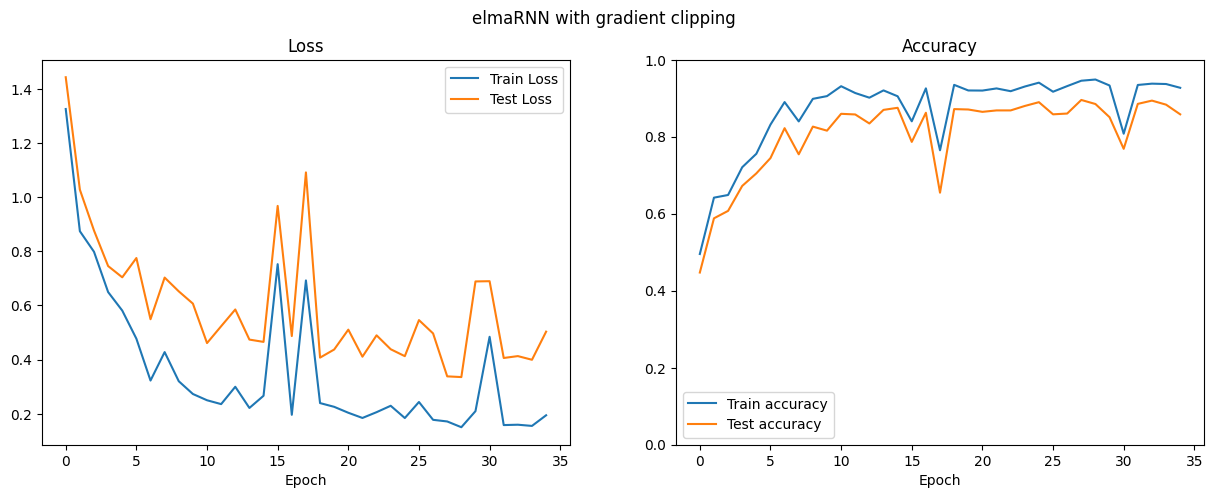

In [22]:
elmaRNN = RNNModel(input_size=n_input_signals, hidden_size=128, layer_size=1, num_classes=N_CLASSES).to(device)

adam = torch.optim.Adam(elmaRNN.parameters(), lr=0.001)
cross_entropy = nn.CrossEntropyLoss()

history = train_model(model=elmaRNN, n_epochs=35, batch_size=64, optimizer=adam, criterion=cross_entropy, gradient_clipping=True)

print_hist(history, 'elmaRNN with gradient clipping')
del elmaRNN

Training model...
Epoch 1, Loss: train=0.6895, test=0.8699 | Accuracy: train=0.6906, test=0.6067
Epoch 2, Loss: train=0.9085, test=0.9105 | Accuracy: train=0.5475, test=0.5348
Epoch 3, Loss: train=0.5277, test=0.7081 | Accuracy: train=0.8045, test=0.7296
Epoch 4, Loss: train=0.7282, test=0.9405 | Accuracy: train=0.6998, test=0.6705
Epoch 5, Loss: train=0.4598, test=0.6470 | Accuracy: train=0.8168, test=0.7577
Epoch 6, Loss: train=0.3890, test=0.5583 | Accuracy: train=0.8569, test=0.8012
Epoch 7, Loss: train=0.3468, test=0.5930 | Accuracy: train=0.8653, test=0.8120
Epoch 8, Loss: train=0.3017, test=0.4351 | Accuracy: train=0.8942, test=0.8371
Epoch 9, Loss: train=0.2916, test=0.6497 | Accuracy: train=0.8864, test=0.8412
Epoch 10, Loss: train=0.3738, test=0.6174 | Accuracy: train=0.8596, test=0.7961
Epoch 11, Loss: train=0.3229, test=0.6031 | Accuracy: train=0.8704, test=0.7883
Epoch 12, Loss: train=0.4194, test=0.5505 | Accuracy: train=0.8785, test=0.8473
Epoch 13, Loss: train=0.2476, t

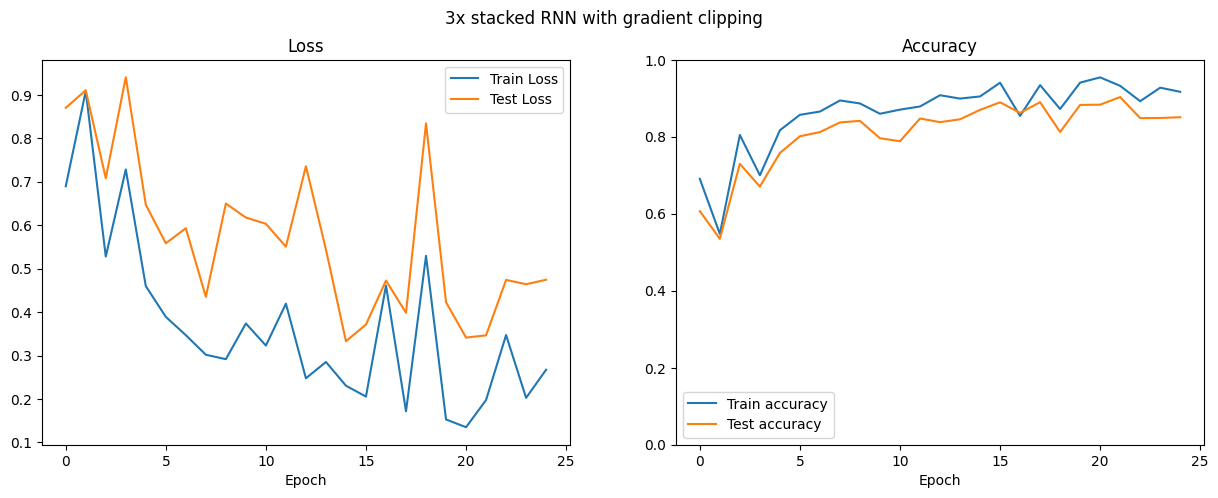

In [23]:
multi_layer_RNN = RNNModel(input_size=n_input_signals, hidden_size=128, layer_size=3, num_classes=N_CLASSES).to(device)

adam = torch.optim.Adam(multi_layer_RNN.parameters(), lr=0.001)
cross_entropy = nn.CrossEntropyLoss()

history = train_model(model=multi_layer_RNN, n_epochs=25, batch_size=64, optimizer=adam, criterion=cross_entropy, gradient_clipping=True)

print_hist(history, '3x stacked RNN with gradient clipping')
del multi_layer_RNN

#### Findings
The difference in performance between the same ElmanRNNs with and without gradient clipping resulted in a 10% improvement in accuracy on the test and train dataset, which is significant.
The increase of the hidden size from 64 to 128 resulted again in a 10% improvement in accuracy on the test and train dataset.
The stacking of 3 RNN layers resulted in ca. 2% improvement in accuracy on the test and and 4% improvement on the train dataset.

### LSTM

Training model...
Epoch 1, Loss: train=0.9893, test=1.0822 | Accuracy: train=0.5985, test=0.5409
Epoch 2, Loss: train=0.6897, test=0.8134 | Accuracy: train=0.7023, test=0.6688
Epoch 3, Loss: train=0.5347, test=0.6796 | Accuracy: train=0.7791, test=0.7499
Epoch 4, Loss: train=0.4133, test=0.7130 | Accuracy: train=0.8674, test=0.7659
Epoch 5, Loss: train=0.2889, test=0.5980 | Accuracy: train=0.8998, test=0.8079
Epoch 6, Loss: train=0.7605, test=1.0862 | Accuracy: train=0.8436, test=0.7577
Epoch 7, Loss: train=0.2214, test=0.5188 | Accuracy: train=0.9238, test=0.8497
Epoch 8, Loss: train=0.2026, test=0.4496 | Accuracy: train=0.9267, test=0.8673
Epoch 9, Loss: train=0.1868, test=0.4991 | Accuracy: train=0.9338, test=0.8554
Epoch 10, Loss: train=0.2031, test=0.5370 | Accuracy: train=0.9342, test=0.8514


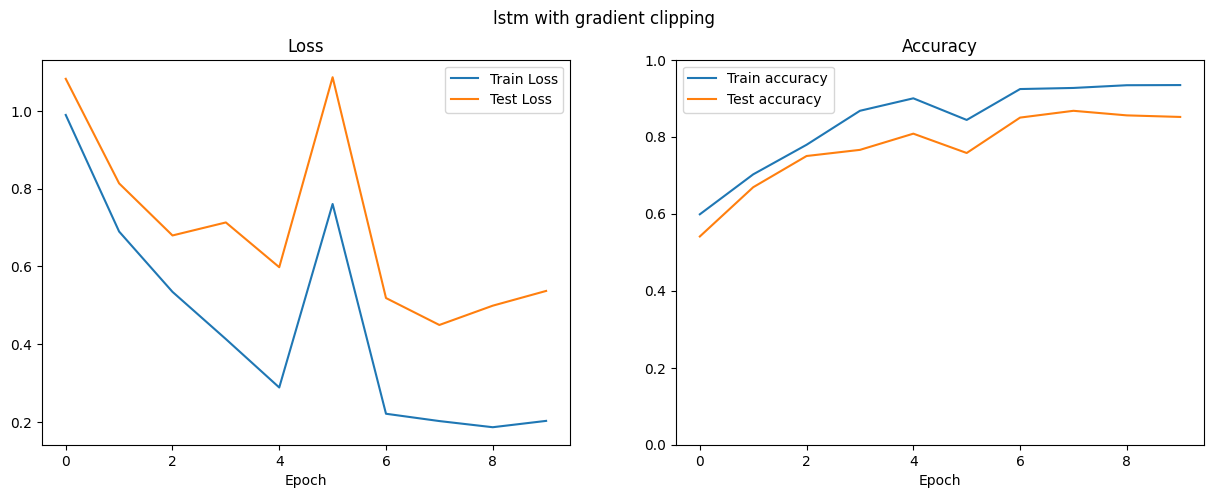

In [24]:
lstm = LSTMModel(input_size=n_input_signals, hidden_size=64, layer_size=1, num_classes=N_CLASSES).to(device)

adam = torch.optim.Adam(lstm.parameters(), lr=0.001)
cross_entropy = nn.CrossEntropyLoss()

history = train_model(model=lstm, n_epochs=10, batch_size=64, optimizer=adam, criterion=cross_entropy, gradient_clipping=True)

print_hist(history, 'lstm with gradient clipping')
del lstm

Training model...
Epoch 1, Loss: train=0.9707, test=1.0985 | Accuracy: train=0.5604, test=0.4968
Epoch 2, Loss: train=0.8270, test=1.0030 | Accuracy: train=0.6493, test=0.6074
Epoch 3, Loss: train=0.5715, test=0.7931 | Accuracy: train=0.7779, test=0.7055
Epoch 4, Loss: train=0.2812, test=0.5098 | Accuracy: train=0.9172, test=0.8392
Epoch 5, Loss: train=0.2220, test=0.5063 | Accuracy: train=0.9178, test=0.8473
Epoch 6, Loss: train=0.1993, test=0.4585 | Accuracy: train=0.9245, test=0.8731
Epoch 7, Loss: train=0.1658, test=0.3675 | Accuracy: train=0.9410, test=0.8744
Epoch 8, Loss: train=0.1579, test=0.4056 | Accuracy: train=0.9437, test=0.8860
Epoch 9, Loss: train=0.1823, test=0.4417 | Accuracy: train=0.9304, test=0.8829
Epoch 10, Loss: train=0.1551, test=0.3170 | Accuracy: train=0.9487, test=0.8928
Epoch 11, Loss: train=0.1456, test=0.4047 | Accuracy: train=0.9440, test=0.8894
Epoch 12, Loss: train=0.1285, test=0.3529 | Accuracy: train=0.9527, test=0.8965


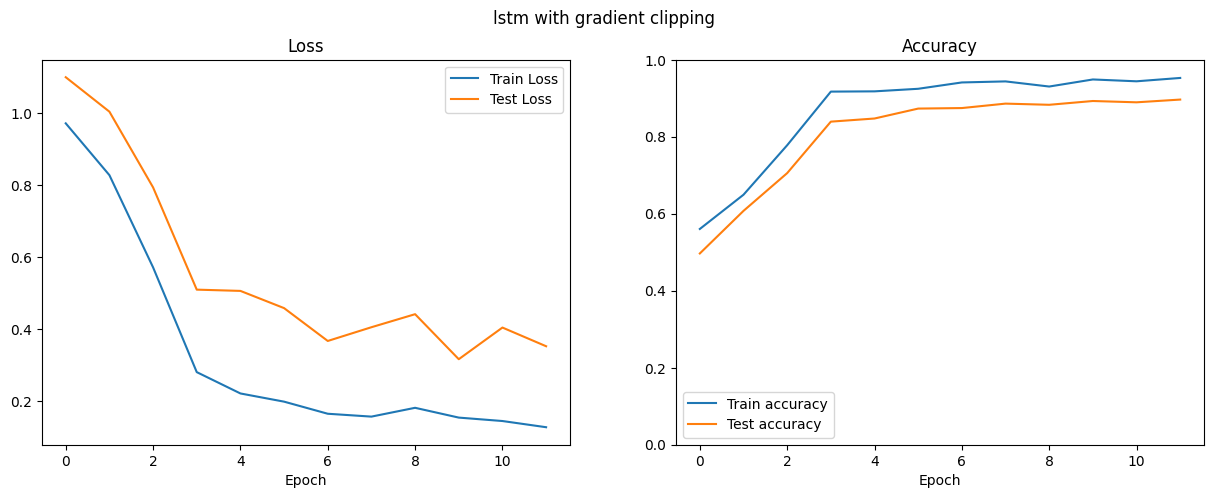

In [25]:
lstm = LSTMModel(input_size=n_input_signals, hidden_size=96, layer_size=1, num_classes=N_CLASSES).to(device)

adam = torch.optim.Adam(lstm.parameters(), lr=0.001)
cross_entropy = nn.CrossEntropyLoss()

history = train_model(model=lstm, n_epochs=12, batch_size=64, optimizer=adam, criterion=cross_entropy, gradient_clipping=True)

print_hist(history, 'lstm with gradient clipping')
del lstm

#### Findings

The LSTM models are much faster in learning and do not need that many epochs to reach similar levels as the ElmanRRS. They also tend to overfit much faster than the ElmanRNNs. The performance is on a similar level as the ElmanRNNs.
The LSTM with 96 hidden units performed slightly better than the one with 64 hidden units and the ElmanRNN with 128 hidden units.

### Stacked LSTMs

Training model...
Epoch 1, Loss: train=0.7459, test=0.8942 | Accuracy: train=0.6211, test=0.5684
Epoch 2, Loss: train=0.6144, test=0.7769 | Accuracy: train=0.7542, test=0.7112
Epoch 3, Loss: train=0.3727, test=0.6028 | Accuracy: train=0.8966, test=0.8035
Epoch 4, Loss: train=0.2795, test=0.6222 | Accuracy: train=0.9051, test=0.8161
Epoch 5, Loss: train=0.2138, test=0.5050 | Accuracy: train=0.9142, test=0.8470
Epoch 6, Loss: train=0.1491, test=0.3850 | Accuracy: train=0.9400, test=0.8863
Epoch 7, Loss: train=0.1382, test=0.4157 | Accuracy: train=0.9484, test=0.8731
Epoch 8, Loss: train=0.1236, test=0.3493 | Accuracy: train=0.9482, test=0.8914
Epoch 9, Loss: train=0.1233, test=0.6078 | Accuracy: train=0.9516, test=0.8666
Epoch 10, Loss: train=0.1542, test=0.6376 | Accuracy: train=0.9381, test=0.8626
Epoch 11, Loss: train=0.1147, test=0.3428 | Accuracy: train=0.9566, test=0.8938
Epoch 12, Loss: train=0.1047, test=0.3696 | Accuracy: train=0.9557, test=0.9013
Epoch 13, Loss: train=0.1144, t

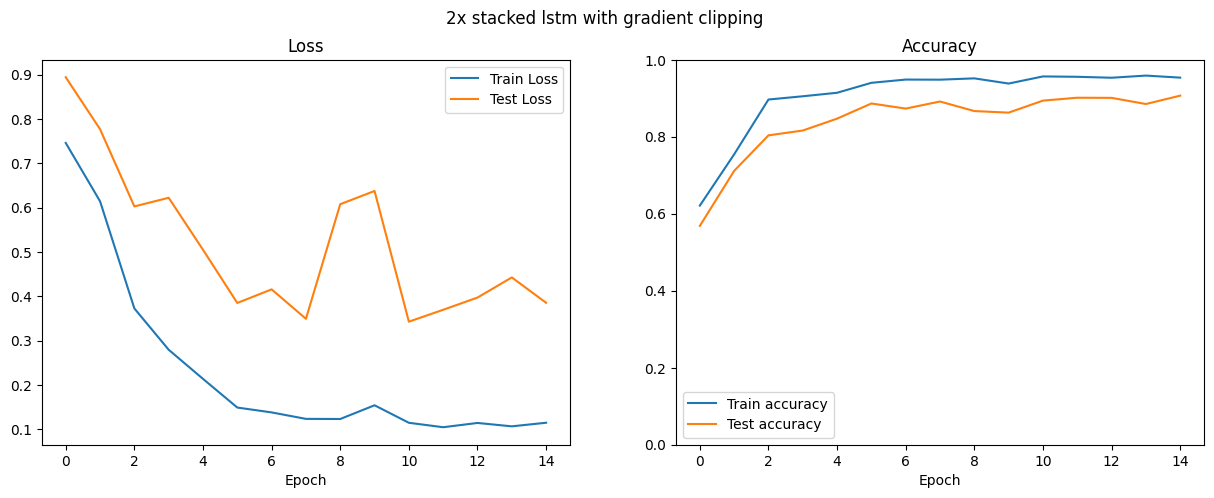

In [27]:
stacked_lstm = LSTMModel(input_size=n_input_signals, hidden_size=64, layer_size=2, num_classes=N_CLASSES).to(device)

adam = torch.optim.Adam(stacked_lstm.parameters(), lr=0.001)
cross_entropy = nn.CrossEntropyLoss()

history = train_model(model=stacked_lstm, n_epochs=15, batch_size=64, optimizer=adam, criterion=cross_entropy, gradient_clipping=True)

print_hist(history, '2x stacked lstm with gradient clipping')
del stacked_lstm

#### Findings

The stacking of 2x LSTM layers did not provide much additional performance.

### CNN (Conv1d)

In [ ]:
cnn_1d = CNN_1D(input_size=signal_sequence_length, num_classes=N_CLASSES).to(device)

adam = torch.optim.Adam(cnn_1d.parameters(), lr=0.001)
cross_entropy = nn.CrossEntropyLoss()

history = train_model(model=cnn_1d, n_epochs=13, batch_size=32, optimizer=adam, criterion=cross_entropy, gradient_clipping=True)

print_hist(history, 'lstm with gradient clipping')
del cnn_1d

Training model...
Epoch 1, Loss: train=0.2195, test=0.3847 | Accuracy: train=0.9223, test=0.8585


In [ ]:
cnn_1d = CNN_1D(input_size=signal_sequence_length, num_classes=N_CLASSES).to(device)

adam = torch.optim.Adam(cnn_1d.parameters(), lr=0.001)
cross_entropy = nn.CrossEntropyLoss()

history = train_model(model=cnn_1d, n_epochs=13, batch_size=32, optimizer=adam, criterion=cross_entropy, gradient_clipping=False)

print_hist(history, 'lstm with gradient clipping')
del cnn_1d

### Findings
The performance of the 1D CNN is impressive. It performs the best of all models with a test accuracy of 0.92.
Another interesting factor is its memory consumption - it uses around 7GB less memory on my notebook.